In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import requests
import json
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')



plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

/Users/sules/Desktop/conjestion/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [13]:
import os
import pandas as pd


folder_2024 = "data/bikes/202405-citibike-tripdata"
folder_2025 = "data/bikes/202505-citibike-tripdata"

def load_monthly_data(folder):
    files = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.csv')]
    return pd.concat([pd.read_csv(f) for f in files], ignore_index=True)

# Load
df_2024 = load_monthly_data(folder_2024)
df_2025 = load_monthly_data(folder_2025)

In [14]:
print(df_2024.columns)

Index(['ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual'],
      dtype='object')


In [15]:
df_2024['started_at'] = pd.to_datetime(df_2024['started_at'])
df_2025['started_at'] = pd.to_datetime(df_2025['started_at'])

df_2024['date'] = df_2024['started_at'].dt.date
df_2025['date'] = df_2025['started_at'].dt.date

In [45]:
# Congestion zone
LAT_MIN = 40.695   # Lower Manhattan 
LAT_MAX = 40.765   # Just below 60th St
LONG_MIN = -74.01  # Avoid West Side Hwy
LONG_MAX = -73.975 # Avoid East River piers

def in_congestion_zone(lat, lng):
    return (lat < LAT_MAX) & (lat > LAT_MIN) & (lng > LONG_MIN) & (lng < LONG_MAX)

# Filter only trips that start in the zone
df_2024_zone = df_2024[in_congestion_zone(df_2024['start_lat'], df_2024['start_lng'])]
df_2025_zone = df_2025[in_congestion_zone(df_2025['start_lat'], df_2025['start_lng'])]

In [46]:
# Prepare the daily aggregates again
daily_2024 = df_2024_zone.groupby(df_2024_zone['date']).size().reset_index(name='trip_count')
daily_2024['cp_period'] = 'before'

daily_2025 = df_2025_zone.groupby(df_2025_zone['date']).size().reset_index(name='trip_count')
daily_2025['cp_period'] = 'after'

# Combine both into one long dataframe
daily_long = pd.concat([daily_2024, daily_2025], ignore_index=True)
#daily_long.rename(columns={'started_at': 'date'}, inplace=True)


daily_long.head()

,date,trip_count,cp_period
0,2024-04-29,3,before
1,2024-04-30,101,before
2,2024-05-01,62511,before
3,2024-05-02,66588,before
4,2024-05-03,57805,before


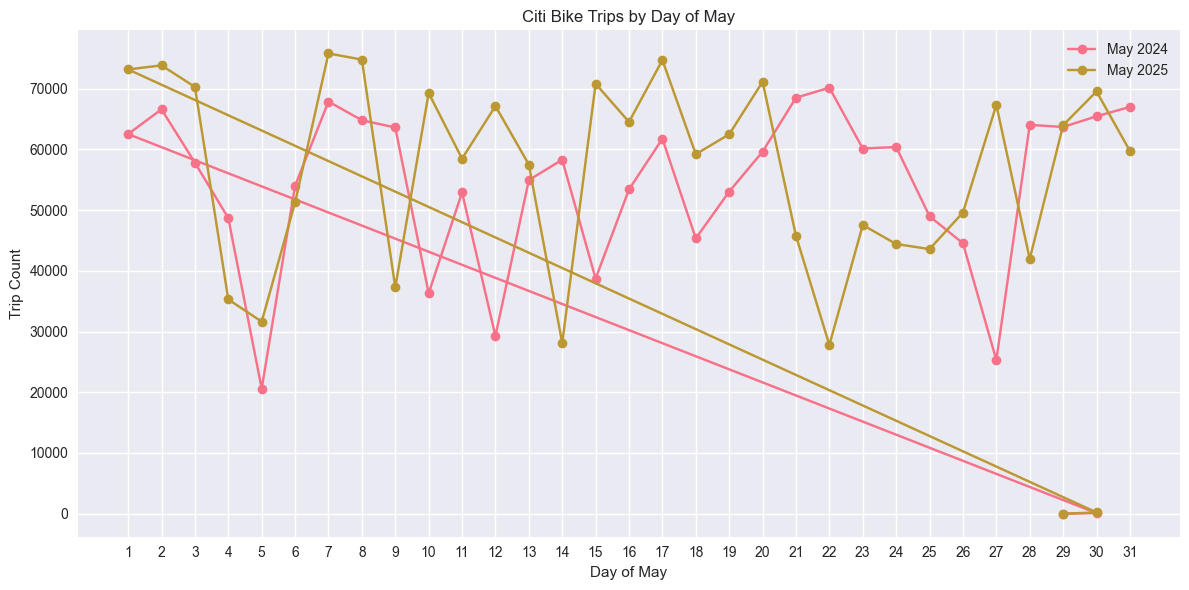

In [47]:
import pandas as pd
import matplotlib.pyplot as plt



# 1) extract day-of-month
daily_2024['day'] = pd.to_datetime(daily_2024['date']).dt.day
daily_2025['day'] = pd.to_datetime(daily_2025['date']).dt.day

# 2) plot
plt.figure(figsize=(12,6))
plt.plot(
    daily_2024['day'], daily_2024['trip_count'],
    marker='o', label='May 2024'
)
plt.plot(
    daily_2025['day'], daily_2025['trip_count'],
    marker='o', label='May 2025'
)

plt.xticks(range(1,32))
plt.xlabel('Day of May')
plt.ylabel('Trip Count')
plt.title('Citi Bike Trips by Day of May')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [59]:
from scipy.stats import ttest_ind

# Split by period
before = daily_long[daily_long['cp_period'] == 'before']['trip_count']
after = daily_long[daily_long['cp_period'] == 'after']['trip_count']

# Drop any NaNs
before = before.dropna()
after = after.dropna()

# Welch's t-test
stat, pvalue = ttest_ind(after, before, equal_var=False)
print(f"Welch’s t = {stat:.2f}, p = {pvalue:.4f}")

if pvalue < 0.05:
    print("Statistically significant difference in daily Citi Bike usage.")
else:
    print("No statistically significant difference.")

Welch’s t = 0.51, p = 0.6109
No statistically significant difference.


In [49]:
# Count trips starting at each station in each month
start_counts_2024 = df_2024_zone.groupby('start_station_id').size().reset_index(name='count_2024')
start_counts_2025 = df_2025_zone.groupby('start_station_id').size().reset_index(name='count_2025')

# Merge t
station_counts = pd.merge(start_counts_2024, start_counts_2025, on='start_station_id', how='outer').fillna(0)

# Calculate percent change
station_counts['abs_change'] = station_counts['count_2025'] - station_counts['count_2024']
station_counts['pct_change'] = (
    (station_counts['count_2025'] - station_counts['count_2024']) / 
    station_counts['count_2024'].replace(0, 1) * 100
)

In [50]:
# Get unique coordinates per start station from 2024 data
station_coords = df_2024_zone.groupby('start_station_id').agg({
    'start_station_name': 'first',
    'start_lat': 'first',
    'start_lng': 'first'
}).reset_index()

# Merge with station trip counts
station_counts_geo = pd.merge(station_counts, station_coords, on='start_station_id', how='left')

# Drop rows with missing lat/lng
station_counts_geo = station_counts_geo.dropna(subset=['start_lat', 'start_lng'])

station_counts_geo.head()

,start_station_id,count_2024,count_2025,abs_change,pct_change,start_station_name,start_lat,start_lng
0,4645.09,474.0,0.0,-474.0,-100.000000,Hicks St & Montague St,40.695128,-73.995951
1,4677.01,331.0,121.0,-210.0,-63.444109,Cadman Plaza E & Tillary St,40.695977,-73.990149
2,4700.06,83.0,24.0,-59.0,-71.084337,Park Ave & St Edwards St,40.696089,-73.978034
3,4710.06,435.0,91.0,-344.0,-79.080460,Jay St & Tech Pl,40.695065,-73.987167
4,4718.08,254.0,113.0,-141.0,-55.511811,Pierrepont St & Monroe Pl,40.695357,-73.993440


In [51]:
import folium

# Center the map roughly on Midtown Manhattan
map_center = [40.75, -73.98]
m = folium.Map(location=map_center, zoom_start=13)

# Add markers
for _, row in station_counts_geo.iterrows():
    lat = row['start_lat']
    lon = row['start_lng']
    pct = row['pct_change']
    count_2024 = row['count_2024']
    count_2025 = row['count_2025']
    
    # Color and size
    color = 'red' if pct > 0 else 'blue'
    radius = min(max(abs(pct) / 2, 3), 15)  # scale marker size

    popup = folium.Popup(
        f"Station: {row['start_station_name']}<br>"
        f"2024 Trips: {int(count_2024)}<br>"
        f"2025 Trips: {int(count_2025)}<br>"
        f"Change: {pct:.1f}%", max_width=300
    )
    
    folium.CircleMarker(
        location=[lat, lon],
        radius=radius,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=popup
    ).add_to(m)

# Show the map
m

In [53]:
num_increased = (station_counts_geo['pct_change'] > 0).sum()
num_decreased = (station_counts_geo['pct_change'] < 0).sum()
num_unchanged = (station_counts_geo['pct_change'] == 0).sum()

print(f"Stations with increased trips: {num_increased}")
print(f"Stations with decreased trips: {num_decreased}")
print(f"Stations with no change:      {num_unchanged}")

Stations with increased trips: 268
Stations with decreased trips: 408
Stations with no change:      0
